In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import supplemental_english as supplement
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler , MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option(('display.max_rows') ,None)
pd.set_option(('display.max_columns') ,None)

In [3]:
train=pd.read_csv('/home/utkarss/Kaggle Projects /Russian car number plate price prediction/train.csv')
test=pd.read_csv('/home/utkarss/Kaggle Projects /Russian car number plate price prediction/test.csv')
train.head()

,id,plate,date,price
0,1,X059CP797,2024-12-26 00:00:00,65000
1,2,Y800MH790,2024-07-12 21:31:37,100000
2,3,A212TX77,2024-04-18 00:00:00,290000
3,4,P001AY199,2025-01-03 00:27:15,680000
4,5,P001AY199,2025-01-10 09:32:41,750000


In [4]:
print(train.shape
,test.shape)

(51635, 4) (7695, 4)


In [5]:
train.info(),test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51635 entries, 0 to 51634
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      51635 non-null  int64 
 1   plate   51635 non-null  object
 2   date    51635 non-null  object
 3   price   51635 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7695 entries, 0 to 7694
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      7695 non-null   int64  
 1   plate   7695 non-null   object 
 2   date    7695 non-null   object 
 3   price   0 non-null      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 240.6+ KB


(None, None)

In [6]:
gov_rows = []
for (letters, (num_from, num_to), region_code), (desc, forbidden, advantage, significance) in supplement.GOVERNMENT_CODES.items():
    gov_rows.append({
        'letters': letters,
        'number_from': num_from,
        'number_to': num_to,
        'region_code': region_code,
        'forbidden_to_buy': bool(forbidden),
        'road_advantage': bool(advantage),
        'significance_level': significance
    })
region_rows = []
for region, codes in supplement.REGION_CODES.items():
    for code in codes:
        region_rows.append({'region_code': code})

df_regions = pd.DataFrame(region_rows)
df_govs = pd.DataFrame(gov_rows)
df_gov = pd.merge(df_govs,on='region_code',how='left',right=df_regions)
df_gov.replace(to_replace=True,value=1,inplace=True)
df_gov.replace(to_replace=False,value=0,inplace=True)
df_gov.shape


/tmp/ipykernel_610388/1375132286.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_gov.replace(to_replace=False,value=0,inplace=True)


(186, 7)

In [7]:
new_train=pd.concat((train,df_gov),axis=1,)
new_test=pd.concat((test,df_gov),axis=1,)
new_train.head()

,id,plate,date,price,letters,number_from,number_to,region_code,forbidden_to_buy,road_advantage,significance_level
0,1,X059CP797,2024-12-26 00:00:00,65000,AMP,0.0,999.0,97,1.0,1.0,10.0
1,2,Y800MH790,2024-07-12 21:31:37,100000,AMP,0.0,999.0,77,0.0,1.0,8.0
2,3,A212TX77,2024-04-18 00:00:00,290000,EKX,0.0,999.0,77,0.0,1.0,6.0
3,4,P001AY199,2025-01-03 00:27:15,680000,EKX,0.0,999.0,97,0.0,1.0,6.0
4,5,P001AY199,2025-01-10 09:32:41,750000,EKX,0.0,999.0,99,0.0,1.0,6.0


In [8]:
def extract_plate_features(df):
    df = df.copy()
    
    df['plate_str'] = df['plate'].astype(str)
    
    # region code: last 2–3 digits
    
    df['region_code'] = df['plate_str'].str.extract(r'(\d{2,3})$')[0]
    
    # prefix letters: first 1–3 characters
    
    df['prefix'] = df['plate_str'].str.extract(r'^([A-ZА-Я]{1,3})')[0]
    
    # numeric block: three digits
    
    df['number'] = df['plate_str'].str.extract(r'([0-9]{3})')[0]
#     df['mid_prefix'] = df['plate_str'].str.extract(r'^([A-ZА-Я]{2,3})')[0]
    # date parts
    
    df['date'] = pd.to_datetime(df['date'])
    df['year']    = df['date'].dt.year
    df['month']   = df['date'].dt.month
    df['day']     = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    
    
    # government‐plate flag
    
    df['is_gov'] = df['prefix'].isin(supplement.GOVERNMENT_CODES).astype(int)
    
    # numeric region code directly
    
    df['region_num'] = pd.to_numeric(df['region_code'], errors='coerce').fillna(0).astype(int)
    
    
    return df

new_train = extract_plate_features(new_train)
new_test = extract_plate_features(new_test)

In [9]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51635 entries, 0 to 51634
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  51635 non-null  int64         
 1   plate               51635 non-null  object        
 2   date                51635 non-null  datetime64[ns]
 3   price               51635 non-null  int64         
 4   letters             186 non-null    object        
 5   number_from         186 non-null    float64       
 6   number_to           186 non-null    float64       
 7   region_code         51635 non-null  object        
 8   forbidden_to_buy    186 non-null    float64       
 9   road_advantage      186 non-null    float64       
 10  significance_level  186 non-null    float64       
 11  plate_str           51635 non-null  object        
 12  prefix              51635 non-null  object        
 13  number              51635 non-null  object    

In [11]:
new_test.isnull().sum()

id                       0
plate                    0
date                     0
price                 7695
letters               7509
number_from           7509
number_to             7509
region_code              0
forbidden_to_buy      7509
road_advantage        7509
significance_level    7509
plate_str                0
prefix                   0
number                   0
year                     0
month                    0
day                      0
weekday                  0
is_gov                   0
region_num               0
dtype: int64

In [12]:
# find object columns
obj_data=new_train.select_dtypes(include=['O'])
obj_data
obj_data.columns

Index(['plate', 'letters', 'region_code', 'plate_str', 'prefix', 'number'], dtype='object')

In [13]:
le_pref = LabelEncoder()
le_reg  = LabelEncoder()
ohe_num = OneHotEncoder()

new_train['pref_enc'] = le_pref.fit_transform(new_train['prefix'])
new_train['plate_enc'] = le_pref.fit_transform(new_train['plate'])
new_train['plate_str_enc'] = le_pref.fit_transform(new_train['plate_str'])
new_train['reg_enc'] = le_reg.fit_transform(new_train['region_code'])
new_train['letters_enc'] = le_pref.fit_transform(new_train['letters'])


new_test['pref_enc'] = le_pref.fit_transform(new_test['prefix'])
new_test['plate_enc'] = le_pref.fit_transform(new_test['plate'])
new_test['plate_str_enc'] = le_pref.fit_transform(new_test['plate_str'])
new_test['reg_enc'] = le_reg.fit_transform(new_test['region_code'])
new_test['letters_enc'] = le_pref.fit_transform(new_test['letters'])

In [16]:
new_train.isnull().sum()

id                        0
plate                     0
date                      0
price                     0
letters               51449
number_from           51449
number_to             51449
region_code               0
forbidden_to_buy      51449
road_advantage        51449
significance_level    51449
plate_str                 0
prefix                    0
number                    0
year                      0
month                     0
day                       0
weekday                   0
is_gov                    0
region_num                0
pref_enc                  0
plate_enc                 0
plate_str_enc             0
reg_enc                   0
letters_enc               0
dtype: int64

In [17]:
X = new_train.drop(columns=['plate', 'plate_str', 'region_code', 'prefix','date','price','letters'],axis=1)
y = new_train['price']
test_X = new_test.drop(columns=['plate', 'plate_str', 'region_code', 'prefix','date','price','letters'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [18]:

st= MinMaxScaler()
st.fit(X_train)

MinMaxScaler()

In [19]:
sc_x_train=st.transform(X_train,)
sc_x_test=st.transform(X_test)
sc_x_train

array([[0.69775729,        nan,        nan, ..., 0.44078525, 1.        ,
        1.        ],
       [0.36809079,        nan,        nan, ..., 0.82299789, 0.86805556,
        1.        ],
       [0.85281016,        nan,        nan, ..., 0.10549491, 0.29861111,
        1.        ],
       ...,
       [0.73900918,        nan,        nan, ..., 0.29662416, 0.86805556,
        1.        ],
       [0.01665569,        nan,        nan, ..., 0.2920833 , 0.875     ,
        1.        ],
       [0.30590309,        nan,        nan, ..., 0.504151  , 0.79861111,
        1.        ]])

In [23]:
sc_x_df=pd.DataFrame(sc_x_train)
sc_x_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.697757,NaN,NaN,NaN,NaN,NaN,0.006012,1.00,0.090909,0.333333,0.166667,0.0,0.100410,0.454545,0.440785,0.440785,1.000000,1.0
1,0.368091,NaN,NaN,NaN,NaN,NaN,0.432866,0.75,0.636364,0.800000,1.000000,0.0,0.815574,0.818182,0.822998,0.822998,0.868056,1.0
2,0.852810,NaN,NaN,NaN,NaN,NaN,0.000000,0.50,0.454545,0.000000,0.500000,0.0,0.180328,0.090909,0.105495,0.105495,0.298611,1.0
3,0.543363,NaN,NaN,NaN,NaN,NaN,0.089178,0.75,0.181818,0.233333,0.666667,0.0,0.200820,0.909091,0.875860,0.875860,0.361111,1.0
4,0.570612,NaN,NaN,NaN,NaN,NaN,0.777555,0.00,0.818182,0.200000,0.500000,0.0,0.091189,0.818182,0.842675,0.842675,0.937500,1.0


In [34]:
cleared=sc_x_df.dropna(axis=1)
cleared.head()

,0,6,7,8,9,10,11,12,13,14,15,16,17
0,0.697757,0.006012,1.00,0.090909,0.333333,0.166667,0.0,0.100410,0.454545,0.440785,0.440785,1.000000,1.0
1,0.368091,0.432866,0.75,0.636364,0.800000,1.000000,0.0,0.815574,0.818182,0.822998,0.822998,0.868056,1.0
2,0.852810,0.000000,0.50,0.454545,0.000000,0.500000,0.0,0.180328,0.090909,0.105495,0.105495,0.298611,1.0
3,0.543363,0.089178,0.75,0.181818,0.233333,0.666667,0.0,0.200820,0.909091,0.875860,0.875860,0.361111,1.0
4,0.570612,0.777555,0.00,0.818182,0.200000,0.500000,0.0,0.091189,0.818182,0.842675,0.842675,0.937500,1.0


/tmp/ipykernel_610388/4254631113.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cleared)
/tmp/ipykernel_610388/4254631113.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sc_x_train)


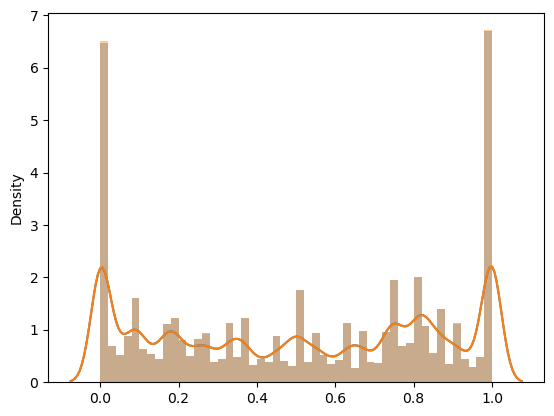

In [32]:
sns.distplot(cleared)
sns.distplot(sc_x_train)
plt.show()

In [39]:
#Dtree
tree_clf = DecisionTreeClassifier(max_depth=80,criterion='log_loss',ccp_alpha=1)
tree_clf.fit(sc_x_train, y_train)

DecisionTreeClassifier(ccp_alpha=1, criterion='log_loss', max_depth=80)

In [40]:
tree_clf.score(sc_x_test,y_test)

0.06216713469545851

In [41]:
predicted=tree_clf.predict(test_X)

/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [48]:
prediction_result=pd.Series([predicted])
prediction_result

0    [100000, 100000, 100000, 100000, 100000, 10000...
dtype: object

In [49]:
submission = pd.DataFrame({
    'id': test['id'],
    'price': predicted
})

In [50]:
submission

,id,price
0,51636,100000
1,51637,100000
2,51638,100000
3,51639,100000
4,51640,100000
5,51641,100000
6,51642,100000
7,51643,100000
8,51644,100000
9,51645,100000
